In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from math import ceil
from tqdm import tqdm
from PIL import Image

from flashtorch.utils import apply_transforms, load_image
from flashtorch.saliency import Backprop

In [4]:
# Set manual seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#torch.use_deterministic_algorithms(True)

In [5]:
# Constants 
dataset_path = "../Dataset"
models_path  = "../models"
BATCH_SIZE = 128

if torch.cuda.is_available():
  _DEVICE = "cuda"
else:
  _DEVICE = "cpu"

In [6]:
# Helper functions
def count_parameters(NN):
    return sum([p.numel() for p in NN.parameters() if p.requires_grad==True])

def get_one_hot_encoder(labels):
    def ohe(target):
        oh_vec=torch.zeros(len(labels), dtype=torch.float)
        oh_vec[target] = 1.
        return oh_vec
    return ohe

In [7]:
# Dataset loader
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
transform_denorm = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor()])
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

dataset_raw = datasets.ImageFolder(f'{dataset_path}/Train', transform=transform_denorm)
dataset = datasets.ImageFolder(f'{dataset_path}/Train', transform=transform, target_transform=get_one_hot_encoder(dataset_raw.classes))

dataset_train, dataset_val = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), 
                                                                      ceil(len(dataset)*0.2)])

dataset_test  = datasets.ImageFolder(f'{dataset_path}/Test', transform=transform)

train_loader = data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = data.DataLoader(dataset_test,  batch_size=BATCH_SIZE, shuffle=True)
val_loader   = data.DataLoader(dataset_val,   batch_size=BATCH_SIZE, shuffle=True)

dataset_raw_val = [dataset_raw[d] for d in dataset_val.indices]
val_raw_loader  = data.DataLoader(dataset_raw_val,  batch_size=BATCH_SIZE, shuffle=True)

In [8]:
trainSteps = len(train_loader.dataset) // BATCH_SIZE
valSteps   = len(val_loader.dataset)  // BATCH_SIZE

In [9]:
# loading icons for signs
img_names = os.listdir(f"{dataset_path}/Vzor")
icons = dict()

for idx, name in enumerate(img_names):
    img_name = f"{dataset_path}/Vzor/{name}"
    image = Image.open(img_name)
    icons[name.split('.')[0]] = image.resize((224,224), Image.LANCZOS)

icons = np.stack([icons[k] for k in dataset.class_to_idx.keys()], axis=0)

In [10]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 7),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(3,3),
    nn.ReLU(),

    nn.Conv2d(32, 64, 5),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(3,3),
    nn.ReLU(),

    nn.Conv2d(64, 64, 5),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(3,3),
    nn.ReLU(),

    nn.Flatten(),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=2304, out_features=256*3, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=256*3, out_features=256, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=256, out_features=len(dataset.classes), bias=True)
)

In [11]:
model(dataset[0][0].unsqueeze(0))

tensor([[ 0.0620,  0.2646,  0.0399,  0.1439, -0.3075, -0.2326,  0.2975,  0.3479,
         -0.1334,  0.4732, -0.2794,  0.2273]], grad_fn=<AddmmBackward0>)

In [12]:
print(f"trainable parameters: {count_parameters(model)}")

trainable parameters: 2128972


In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
model.load_state_dict(torch.load(f"{models_path}/v3.pt", weights_only=True))

<All keys matched successfully>

In [ ]:
N_EPOCH = 100

model.to(_DEVICE)
progress_bar = tqdm(range(0, N_EPOCH))
H = {"train_loss": [],	  "val_loss": []}
for epoch in progress_bar:
    totalTrainLoss = 0
    totalValLoss = 0
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(_DEVICE)
        outputs = model(inputs)
        targets = targets.to(torch.float32).to(_DEVICE)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        totalTrainLoss += loss

    with torch.no_grad():
      model.eval()
      for inputs, targets in val_loader:
        inputs = inputs.to(_DEVICE)
        outputs = model(inputs)
        targets = targets.to(_DEVICE)
        totalValLoss += loss_fn(outputs, targets)

    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss   = totalValLoss / valSteps
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    progress_bar.set_description(f"Train loss: {avgTrainLoss:.6f} | Val loss: {avgValLoss:.6f}")

In [12]:
import pickle
# Save train history
with open('loss_Custom.pickle', 'wb') as handle:
    pickle.dump(H, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
torch.save(model.state_dict(), f"{models_path}/v3.pt")

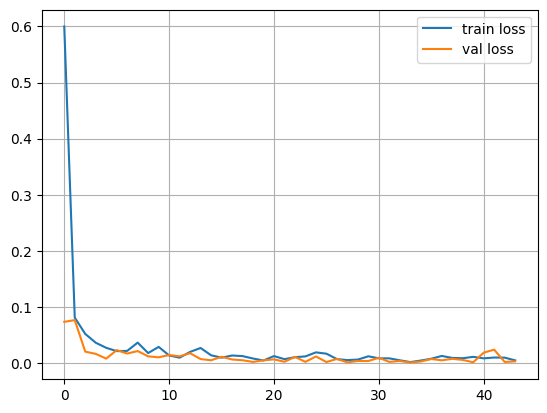

In [15]:
plt.plot(H['train_loss'], label = "train loss")
plt.plot(H['val_loss'], label = "val loss")
plt.legend()
plt.grid()
#plt.yscale('log')
#plt.xscale('log')
plt.show()

In [15]:
def predict_all(loader, transform=lambda x: x):
    predictions = list()
    model.to(_DEVICE)
    model.eval()
    with torch.no_grad():
        for _inputs, _labels in tqdm(loader):
            _inputs = _inputs.to(_DEVICE)
            inputs = transform(_inputs)
            outputs = model(inputs)
            predictions.append(
                [_inputs.cpu().detach(), outputs.cpu().detach(), _labels.cpu().detach()]
            )
    return torch.cat([p[0] for p in predictions]), \
           torch.cat([p[1] for p in predictions]), \
           torch.cat([p[2] for p in predictions])

In [16]:
def show_predictions(predictions, N, rand=True):
    if rand:
        selector = np.random.choice(range(0,len(predictions[0])), N)
    else:
        selector = list(range(0,N))
        
    source, est, _ = predictions
    source = source[selector]
    est = est[selector]
    fig, axs = plt.subplots(N, 3)
    for i, (s_img, prob) in enumerate(zip(source, est)):
        axs[i, 0].imshow(F.to_pil_image(s_img))
        axs[i, 0].axis("off")
        
        prob_norm = torch.nn.functional.softmax(prob, dim=0).cpu()
        
        idx = np.argmax(prob_norm)
        axs[i, 1].imshow(icons[idx])
        axs[i, 1].axis("off")

        axs[i, 2].bar(dataset.class_to_idx.values(), prob_norm)
        axs[i, 2].axis("on")

    #fig.tight_layout() 
    fig.subplots_adjust(hspace=0.15, wspace=0)
        
    return fig, axs

In [17]:
predictions = predict_all(val_raw_loader, transform=normalize)

100%|██████████| 24/24 [00:02<00:00,  8.89it/s]


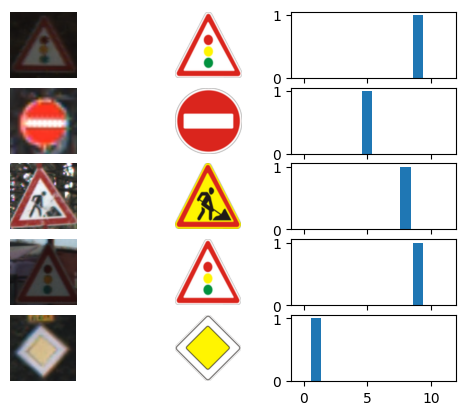

In [18]:
_ = show_predictions(predictions, 5)

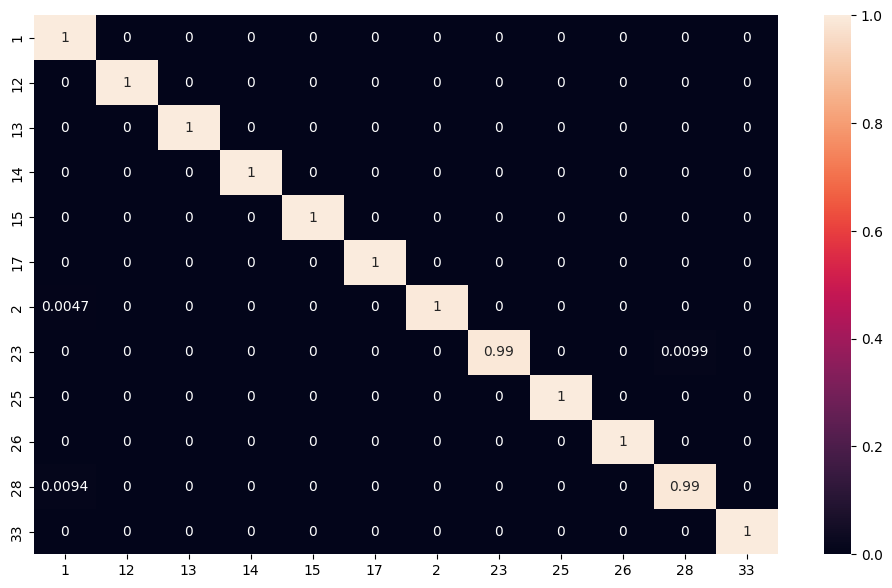

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for input, output, label in zip(*predictions):
        output = torch.max(output, dim=-1).indices.cpu().numpy()
        y_pred.append(output)
        y_true.append(label.cpu().numpy()) 


classes = dataset.classes

# Confusion matrix

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = classes,
                     columns = classes)
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [20]:
print(classification_report(y_true, y_pred, target_names=classes, digits=5))

              precision    recall  f1-score   support

           1    0.99336   1.00000   0.99667       449
          12    1.00000   1.00000   1.00000       429
          13    1.00000   1.00000   1.00000       438
          14    1.00000   1.00000   1.00000       178
          15    1.00000   1.00000   1.00000       107
          17    1.00000   1.00000   1.00000       222
           2    1.00000   0.99532   0.99765       427
          23    1.00000   0.99010   0.99502       101
          25    1.00000   1.00000   1.00000       277
          26    1.00000   1.00000   1.00000       145
          28    0.99057   0.99057   0.99057       106
          33    1.00000   1.00000   1.00000       139

    accuracy                        0.99867      3018
   macro avg    0.99866   0.99800   0.99833      3018
weighted avg    0.99868   0.99867   0.99867      3018



Feature maps for layer: 0


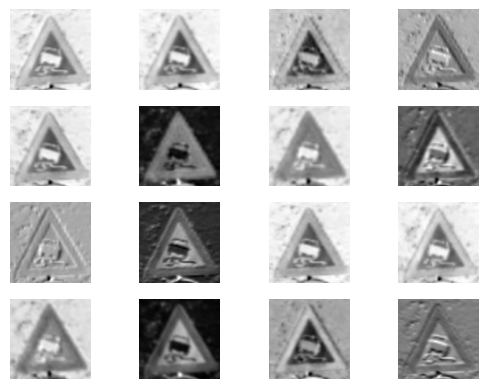

Feature maps for layer: 4


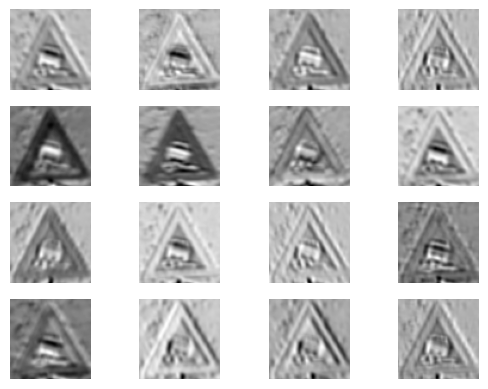

Feature maps for layer: 8


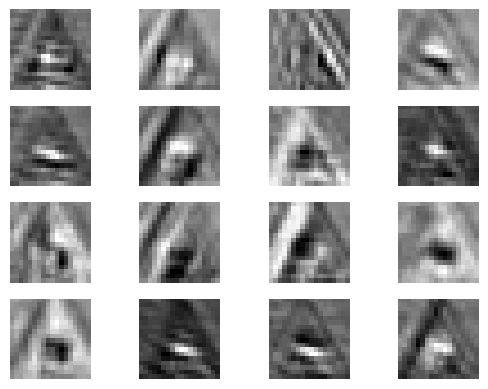

In [22]:
def visualize_feature_maps(model, image):
  activation = {}
  def get_activation(name):
    def hook(model, input, output):
      activation[name] = output.detach()
    return hook

  for name, layer in model.named_modules():
    if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d)):
      layer.register_forward_hook(get_activation(name))

  _ = model(image)

  for name, features in activation.items():
    if isinstance(model._modules[name], (nn.Conv2d, nn.ConvTranspose2d)):
      print(f"Feature maps for layer: {name}")
      feature_num = features.shape[1]

      for i in range(min(feature_num, 16)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(features[0, i, :, :].cpu().numpy(), cmap='gray')
        plt.axis('off')
      plt.show()


inp, _ = dataset_val.__getitem__(0)
inp = inp[None, :, :, :].to(_DEVICE)

visualize_feature_maps(model, inp)

Visualizing filters for layer 1 (Conv2d):


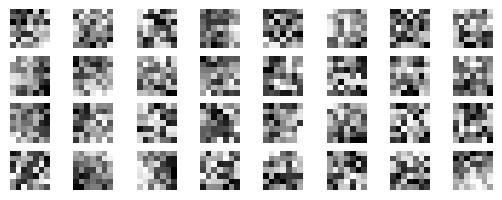

Visualizing filters for layer 5 (Conv2d):


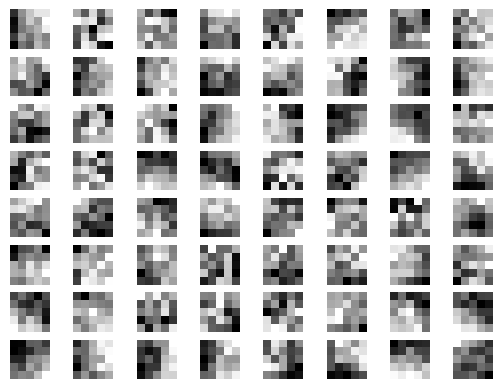

In [25]:
def visualize_filters(model):
  counter = 0
  for i, layer in enumerate(model.children()):
    if isinstance(layer, nn.Conv2d):
      if counter < 2:
        counter += 1
        filters = layer.weight.detach().cpu().numpy()
        filter_num = filters.shape[0]
        print(f"Visualizing filters for layer {i+1} (Conv2d):")

        for j in range(min(filter_num, 64)):  # Show a maximum of 16 filters
          plt.subplot(8, 8, j + 1)
          plt.imshow(filters[j, 0, :, :], cmap='gray')
          plt.axis('off')
        plt.show()

visualize_filters(model)